# Germ layers and differential gene expression analysis

In this heatmap, we recover the output from the previous notebook and plot some heatmaps as a validation step. 
Next, Plots for germ layers and differential gene expression between gastruloids grown in either Chi or ChiSB43 conditions is performed.

In [45]:
import glob
import Colors
from scipy.cluster.hierarchy import dendrogram, linkage
from neupy import algorithms
from scipy.stats.stats import pearsonr   
from scipy.interpolate import interp1d
import itertools as it
import statsmodels.stats.multitest as multi

In [46]:
Colors.colors[15] = '#FF0000'

In [47]:
#np.random.seed(41151)

# read data

In [48]:
mdfChi = read_csv('../results_postRevJan19/hGlds_Chi_zscore.tsv', sep = '\t', index_col = 0)
mdfSB = read_csv('../results_postRevJan19/hGlds_ChiSB43_zscore.tsv', sep = '\t', index_col = 0)

In [49]:
mndfChi = read_csv('../results_postRevJan19/hGlds_Chi_norm.tsv', sep = '\t', index_col = 0)
mndfSB = read_csv('../results_postRevJan19/hGlds_ChiSB43_norm.tsv', sep = '\t', index_col = 0)

In [50]:
mdfsChi = [mdfChi[[idx for idx in mdfChi.columns if 'hG01-chi' in idx]], 
           mdfChi[[idx for idx in mdfChi.columns if 'hG02-chi' in idx]]]

mdfsSB = [mdfSB[[idx for idx in mdfSB.columns if 'hG03-sb' in idx]], 
          mdfSB[[idx for idx in mdfSB.columns if 'hG04-sb' in idx]]]

In [51]:
mndfsChi = [mndfChi[[idx for idx in mndfChi.columns if 'hG01-chi' in idx]], 
           mndfChi[[idx for idx in mndfChi.columns if 'hG02-chi' in idx]]]

mndfsSB = [mndfSB[[idx for idx in mndfSB.columns if 'hG03-sb' in idx]], 
          mndfSB[[idx for idx in mndfSB.columns if 'hG04-sb' in idx]]]

In [52]:
0.5*sum([df.sum().sum() for df in mndfsChi]), 0.5*sum([df.sum().sum() for df in mndfsSB])

(5088738.500000058, 11673423.00000004)

In [53]:
# mndfsChi = [1e5*df/df.sum().sum() for df in mndfsChi]
# mndfsSB = [1e5*df/df.sum().sum() for df in mndfsSB]

mndfsChi = [5088738.500000058*df/df.sum().sum() for df in mndfsChi]
mndfsSB = [11673423.00000004*df/df.sum().sum() for df in mndfsSB]

In [54]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

In [55]:
mdf_all = mergeDfs([mdfChi,mdfSB])

In [56]:
mndfChi = mergeDfs(mndfsChi)
mndfSB = mergeDfs(mndfsSB)

In [57]:
corrgenes_chi = read_csv('../results_postRevJan19/comparison_chi_chisb43/corr_genes_chi.tsv', sep = '\t', index_col=0)
corrgenes_sb = read_csv('../results_postRevJan19/comparison_chi_chisb43/corr_genes_chiSB43.tsv', sep = '\t', index_col=0)

# gene selction

In [58]:
pvth = 0.01
gl_chi = corrgenes_chi.index[corrgenes_chi['adj-pv']<pvth]

pvth = 0.01
gl_SB = corrgenes_sb.index[corrgenes_sb['adj-pv']<pvth]
len(gl_chi), len(gl_SB)

(810, 1245)

# average gastruloids

In [59]:
def averageGastruloid(mzdf,n):
    mdf = mzdf.T
    glds = set(['-'.join(c.rsplit('-')[-2:]) for c in mdf.index])
    mdf['x'] = 0
    for gld in glds:
        idxs = [c for c in mdf.index if gld == '-'.join(c.rsplit('-')[-2:])]
        xra = np.linspace(0,1,len(idxs))
        for idx, x in zip(idxs, xra):
            mdf.loc[idx,'x'] = x
    mdf = mdf.sort_values(by = 'x', ascending = True)
    xdf = pd.DataFrame(columns = mdf.columns, index = range(n))
    xra = np.linspace(0,1,n+1)
    for i in range(len(xra)-1):
        idxs = [c for c in mdf.index if xra[i]<mdf.loc[c,'x']<=xra[i+1]]
        xdf.loc[i] = mdf.loc[idxs].mean()
    del xdf['x']
    return xdf.T

In [60]:
mdfChi_av = averageGastruloid(mdfChi, 22).astype(float)
mdfSB_av = averageGastruloid(mdfSB, 41).astype(float)

In [61]:
mndfChi_av = averageGastruloid(mndfChi, 22).astype(float)
mndfSB_av = averageGastruloid(mndfSB, 41).astype(float)

In [65]:
mdfsSB[0].to_csv('../SB43_gld1_zscore.tsv', sep = '\t')
mdfsSB[1].to_csv('../SB43_gld2_zscore.tsv', sep = '\t')
mdfSB_av.to_csv('../SB43_average_zscore.tsv', sep = '\t')

# Clusters

In [18]:
g_annotate = ['TBXT','NODAL','CDX2','RSPO3','SOX1','SOX2','WNT3a','FGF8','UNCX','TCF15','ALDH1A2',
            'MESP1','MESP2','RIPPLY2','DPPA5','GATA6','MEOX1','TBX6','CYP26A1','GATA4','HAND1','TBX1','PAX6',
            'ZEB2']

In [19]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [20]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

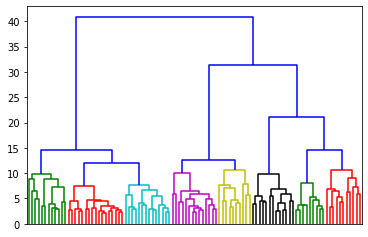

In [21]:
somhcl_Chi_df = comboCluster(mdfChi, gl_chi, cth=11)

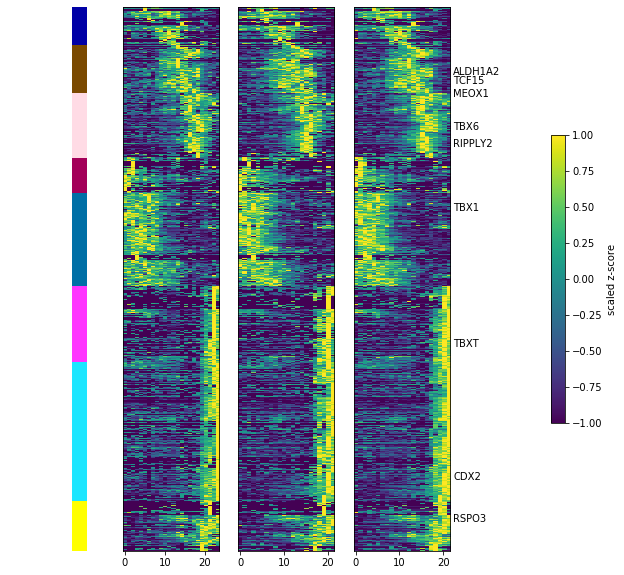

In [22]:
plt.figure(figsize=(10,10))

gene_order = somhcl_Chi_df.sort_values(by=['hcl','som']).index
Npl = 3+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somhcl_Chi_df['hcl']):
    y = 1.0*len(somhcl_Chi_df[somhcl_Chi_df['hcl'] == i])/len(somhcl_Chi_df)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(mdfsChi + [mdfChi_av]):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft=False, labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('_')[1] if g.rsplit('_')[1] in g_annotate else '' for g in gene_order[::-1]])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.show()

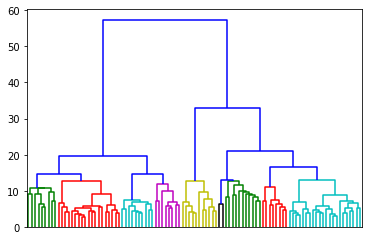

In [23]:
somhcl_SB_df = comboCluster(mdfSB, gl_SB, cth=13)

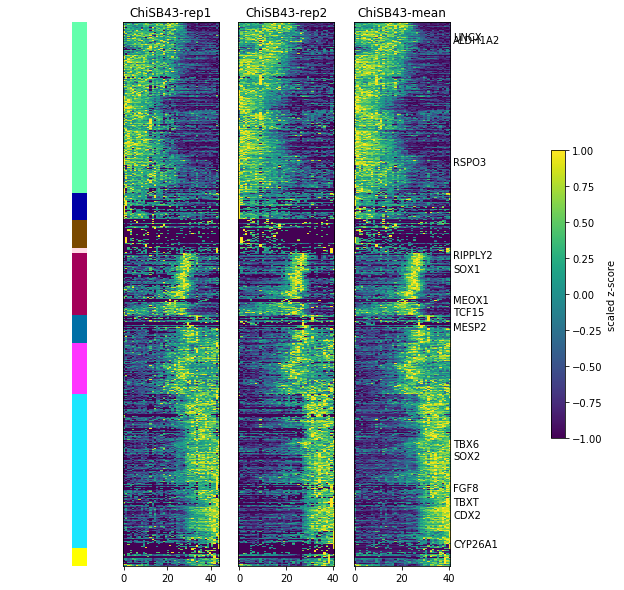

In [24]:
plt.figure(figsize=(10,10))

gene_order = somhcl_SB_df.sort_values(by=['hcl','som']).index
Npl = 3+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somhcl_SB_df['hcl']):
    y = 1.0*len(somhcl_SB_df[somhcl_SB_df['hcl'] == i])/len(somhcl_SB_df)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

titles = ['ChiSB43-rep1', 'ChiSB43-rep2', 'ChiSB43-mean']
for i, df in enumerate(mdfsSB + [mdfSB_av]):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(titles[i])
plt.tick_params(axis='y', labelleft=False, labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('_')[1] if g.rsplit('_')[1] in g_annotate else '' for g in gene_order[::-1]])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results_postRevJan19/final_figs/heatmap_chisb43.pdf')

plt.show()

In [25]:
somhcl_SB_df.to_csv('../results_postRevJan19/final_figs/heatmap_chisb43.tsv', sep = '\t')

In [26]:
set(somhcl_SB_df['hcl'])

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [27]:
len(mdfsSB)

2

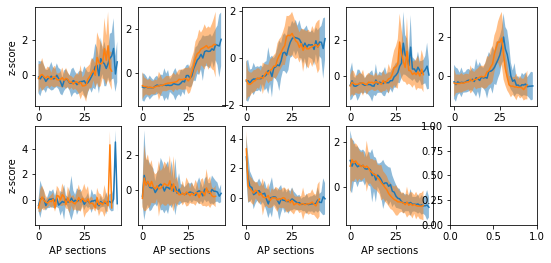

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (9,4))
for cl in set(somhcl_SB_df['hcl']):
    nr = np.mod(cl,5); nc = int(cl/5)
    for df in mdfsSB:
        x = range(len(df.columns))
        y0 = df.loc[somhcl_SB_df[somhcl_SB_df['hcl']==cl].index].mean()
        y1 = y0 + df.loc[somhcl_SB_df[somhcl_SB_df['hcl']==cl].index].std()
        y2 = y0 - df.loc[somhcl_SB_df[somhcl_SB_df['hcl']==cl].index].std()
        ax[nc][nr].fill_between(x, y1, y2, alpha = 0.5)
        ax[nc][nr].plot(x, y0)
    if nr == 0:
        ax[nc][nr].set_ylabel('z-score')
    if nc == 1:
        ax[nc][nr].set_xlabel('AP sections')
#ax[1][3].set_xticks([]); ax[1][3].set_yticks([])

plt.savefig('../results_postRevJan19/final_figs/lineplots_chisb43.pdf', bbox_inches = 'tight')
plt.show()

# Plots

1.	Heatmap of Chi and ChiSB43 average gastruloids, including reproducibly localised and uniquely localised genes together in the same plot (so we can see those genes for which the localisation was lost on Nodal inhibition)

In [29]:
gl_SBandChi = list(set(list(gl_SB) + list(gl_chi)))

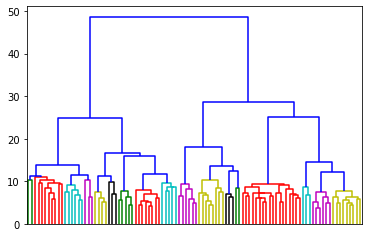

In [30]:
somhcl_Chi_df = comboCluster(mdf_all, gl_SBandChi, cth=11)

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


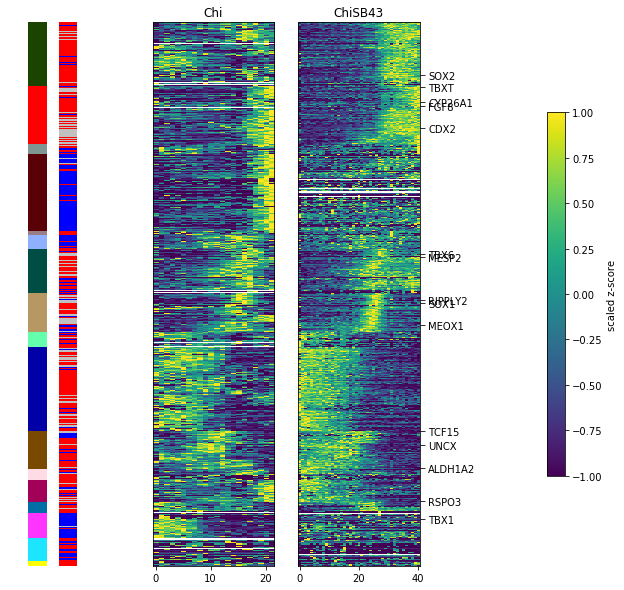

In [31]:
plt.figure(figsize=(10,10))

gene_order = somhcl_Chi_df.sort_values(by=['hcl','som']).index
Npl = 2+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 3.5
for i in set(somhcl_Chi_df['hcl']):
    y = 1.0*len(somhcl_Chi_df[somhcl_Chi_df['hcl'] == i])/len(somhcl_Chi_df)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
xb = 4; y0 = 0; y = 1.0/len(somhcl_Chi_df)
for g in gene_order:
    if g in gl_SB and g in gl_chi:
        plt.bar([xb], [y], bottom = y0, width = 0.3, color = 'silver')
    if g in gl_SB and g not in gl_chi:
        plt.bar([xb], [y], bottom = y0, width = 0.3, color = 'r')
    if g not in gl_SB and g in gl_chi:
        plt.bar([xb], [y], bottom = y0, width = 0.3, color = 'b')
    y0 += y
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(3,5)

titles = ['Chi','ChiSB43']
for i, df in enumerate([mdfChi_av] + [mdfSB_av]):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(titles[i])
#plt.tick_params(axis='y', labelleft=False, labelright='on', length = 0)
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)

plt.yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate], [g.rsplit('_')[1] for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results_postRevJan19/final_figs/heatmap_avChi_avChiSB43_reprChi_reprChiSB43.pdf', bbox_inches = 'tight')
somhcl_Chi_df.to_csv('../results_postRevJan19/final_figs/heatmap_avChi_avChiSB43_reprChi_reprChiSB43.tsv', sep = '\t')

plt.show()

In [34]:
somhcl_Chi_df = read_csv('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/SupFile5.tsv', sep = '\t', index_col=0)

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


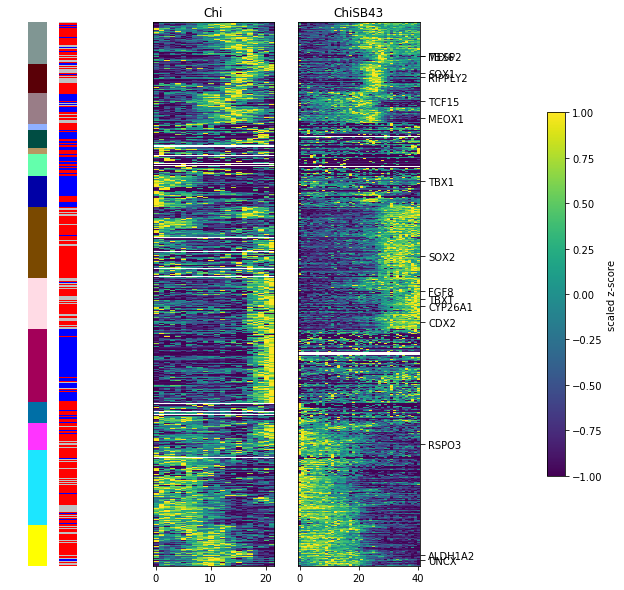

In [36]:
plt.figure(figsize=(10,10))

gene_order = somhcl_Chi_df.sort_values(by=['hcl','som']).index
Npl = 2+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 3.5
for i in set(somhcl_Chi_df['hcl']):
    y = 1.0*len(somhcl_Chi_df[somhcl_Chi_df['hcl'] == i])/len(somhcl_Chi_df)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
xb = 4; y0 = 0; y = 1.0/len(somhcl_Chi_df)
for g in gene_order:
    if g in gl_SB and g in gl_chi:
        plt.bar([xb], [y], bottom = y0, width = 0.3, color = 'silver')
    if g in gl_SB and g not in gl_chi:
        plt.bar([xb], [y], bottom = y0, width = 0.3, color = 'r')
    if g not in gl_SB and g in gl_chi:
        plt.bar([xb], [y], bottom = y0, width = 0.3, color = 'b')
    y0 += y
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(3,5)

titles = ['Chi','ChiSB43']
for i, df in enumerate([mdfChi_av] + [mdfSB_av]):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(titles[i])
#plt.tick_params(axis='y', labelleft=False, labelright='on', length = 0)
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)

plt.yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate], [g.rsplit('_')[1] for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

#plt.savefig('../results_postRevJan19/final_figs/heatmap_avChi_avChiSB43_reprChi_reprChiSB43.pdf', bbox_inches = 'tight')
#somhcl_Chi_df.to_csv('../results_postRevJan19/final_figs/heatmap_avChi_avChiSB43_reprChi_reprChiSB43.tsv', sep = '\t')

plt.show()

In [39]:
writer = pd.ExcelWriter('../../../WritingPapers/hGldPaper_Oct2019/source_data/fig5g.xlsx')

somhcl_Chi_df.loc[gene_order,'hcl'].to_excel(writer, sheet_name = 'clusters')

somhcl_Chi_df['color'] = 'b'
for g in gene_order:
    if g in gl_SB and g in gl_chi:
        somhcl_Chi_df.loc[g,'color'] = 'g'
    if g in gl_SB and g not in gl_chi:
        somhcl_Chi_df.loc[g,'color'] = 'r'
    if g not in gl_SB and g in gl_chi:
        somhcl_Chi_df.loc[g,'color'] = 'b'
somhcl_Chi_df.loc[gene_order,'color'].to_excel(writer, sheet_name = 'localisation')

titles = ['Chi','ChiSB43']
for i, df in enumerate([mdfChi_av] + [mdfSB_av]):
    df.loc[gene_order][::-1].to_excel(writer, sheet_name = titles[i])

writer.close()

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (9,4))
for cl in set(somhcl_Chi_df['hcl']):
    nr = np.mod(cl,5); nc = int(cl/5)
    for df in mdfsSB:
        x = range(len(df.columns))
        y0 = df.loc[somhcl_Chi_df[somhcl_Chi_df['hcl']==cl].index].mean()
        y1 = y0 + df.loc[somhcl_Chi_df[somhcl_Chi_df['hcl']==cl].index].std()
        y2 = y0 - df.loc[somhcl_Chi_df[somhcl_Chi_df['hcl']==cl].index].std()
        ax[nc][nr].fill_between(x, y1, y2, alpha = 0.5)
        ax[nc][nr].plot(x, y0)
    if nr == 0:
        ax[nc][nr].set_ylabel('z-score')
    if nc == 1:
        ax[nc][nr].set_xlabel('AP sections')
#ax[1][3].set_xticks([]); ax[1][3].set_yticks([])

plt.savefig('../results_postRevJan19/final_figs/lineplots_chi.pdf', bbox_inches = 'tight')
plt.show()

2.	Differential expression plot with both reproducibly localised and uniquely localised genes together (same reasoning as above)

In [32]:
n10nfdfsChi = 1e5*mndfChi_av/mndfChi_av.sum().sum() 
n10nfdfsSB = 1e5*mndfSB_av/mndfSB_av.sum().sum()

# n10nfdfsChi = mndfChi_av
# n10nfdfsSB = mndfSB_av

In [33]:
dex_ChiSB = pd.DataFrame({
    'total-Chi': n10nfdfsChi.sum(axis=1),
    'total-SB': n10nfdfsSB.sum(axis=1),
    'total-mean': {idx: np.mean(list(n10nfdfsChi.loc[idx].values) + list(n10nfdfsSB.loc[idx].values)) for idx in set(list(n10nfdfsChi.index)+list(n10nfdfsSB.index)) if idx in n10nfdfsChi.index and idx in n10nfdfsSB.index}
})

In [34]:
dex_ChiSB = dex_ChiSB.loc[[idx for idx in dex_ChiSB.index if idx in mndfChi.index and idx in mndfSB.index]]

In [35]:
dex_ChiSB['log2FC'] = np.log2((dex_ChiSB['total-Chi']+1e-10)/(dex_ChiSB['total-SB']+1e-10))
dex_ChiSB['log2mu'] = np.log2(0.5*(dex_ChiSB['total-Chi']+dex_ChiSB['total-SB'])) # np.log2(dex_Chi['total-mean'])


In [36]:
dex_ChiSB['prob-Chi'] = dex_ChiSB['total-Chi']/dex_ChiSB['total-Chi'].sum()
dex_ChiSB['prob-SB'] = dex_ChiSB['total-SB']/dex_ChiSB['total-SB'].sum()

dex_ChiSB['N-Chi'] = dex_ChiSB['total-Chi'].sum()
dex_ChiSB['N-SB'] = dex_ChiSB['total-SB'].sum()



In [37]:
fdex_ChiSB = dex_ChiSB.loc[[g for g in dex_ChiSB.index if g in gl_SBandChi]]


In [38]:
from scipy.stats import binom

def dex_Pval(expression, total, prob):
    expression, total = int(expression), int(total)
    pv = binom.cdf(expression, total, prob)
    if pv > 0.5:
        pv = 1-pv
    return pv

In [39]:
fdex_ChiSB['PvalChi'] = fdex_ChiSB.apply(lambda x: dex_Pval(x['total-Chi'],x['N-Chi'],x['prob-SB']), axis = 1)
fdex_ChiSB['PvalSB'] = fdex_ChiSB.apply(lambda x: dex_Pval(x['total-SB'],x['N-SB'],x['prob-Chi']), axis = 1)


In [40]:
fdex_ChiSB.head()

,total-Chi,total-SB,total-mean,log2FC,log2mu,prob-Chi,prob-SB,N-Chi,N-SB,PvalChi,PvalSB
ENSG00000000003_TSPAN6__X,48.402820,51.033089,1.578348,-0.076342,5.635695,0.000484,0.000511,99933.997212,99953.229344,0.369691,0.321659
ENSG00000001630_CYP51A1__7,23.007441,35.376497,0.926729,-0.620691,4.867500,0.000230,0.000354,99933.997212,99953.229344,0.017995,0.007309
ENSG00000002834_LASP1__17,9.543232,7.134925,0.264733,0.419580,3.059888,0.000095,0.000071,99933.997212,99953.229344,0.183287,0.264006
ENSG00000003436_TFPI__2,5.426150,0.657838,0.096571,3.044124,1.605017,0.000054,0.000007,99933.997212,99953.229344,0.000064,0.004395
ENSG00000004399_PLXND1__3,3.452802,1.075323,0.071875,1.682997,1.178914,0.000035,0.000011,99933.997212,99953.229344,0.023942,0.140885


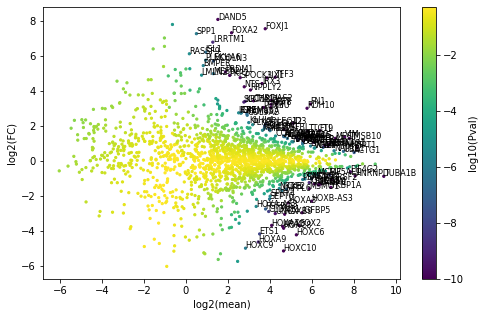

In [41]:
# Differential gene expression analysis
plt.figure(figsize=(5*1.6,5))

plt.subplot(111)
plt.scatter(fdex_ChiSB['log2mu'], fdex_ChiSB['log2FC'], s = 5, c = np.log10(fdex_ChiSB['PvalChi']+1e-10))
plt.colorbar(label = 'log10(Pval)')
for g in fdex_ChiSB[np.log10(fdex_ChiSB['PvalChi'])<-5].index:
    x = fdex_ChiSB.loc[g,'log2mu']
    y = fdex_ChiSB.loc[g,'log2FC']
    plt.text(x, y, g.rsplit('_')[1], fontsize = 8)
plt.xlabel('log2(mean)')
plt.ylabel('log2(FC)')

fdex_ChiSB.to_csv('../results_postRevJan19/final_figs/dex_chiVSchiSB43_sameNormalization.tsv', sep = '\t')
plt.savefig('../results_postRevJan19/final_figs/dex_chiVSchiSB43_sameNormalization.pdf', bbox_inches = 'tight')

plt.show()

In [42]:
fdex_ChiSB.head()

,total-Chi,total-SB,total-mean,log2FC,log2mu,prob-Chi,prob-SB,N-Chi,N-SB,PvalChi,PvalSB
ENSG00000000003_TSPAN6__X,48.402820,51.033089,1.578348,-0.076342,5.635695,0.000484,0.000511,99933.997212,99953.229344,0.369691,0.321659
ENSG00000001630_CYP51A1__7,23.007441,35.376497,0.926729,-0.620691,4.867500,0.000230,0.000354,99933.997212,99953.229344,0.017995,0.007309
ENSG00000002834_LASP1__17,9.543232,7.134925,0.264733,0.419580,3.059888,0.000095,0.000071,99933.997212,99953.229344,0.183287,0.264006
ENSG00000003436_TFPI__2,5.426150,0.657838,0.096571,3.044124,1.605017,0.000054,0.000007,99933.997212,99953.229344,0.000064,0.004395
ENSG00000004399_PLXND1__3,3.452802,1.075323,0.071875,1.682997,1.178914,0.000035,0.000011,99933.997212,99953.229344,0.023942,0.140885


In [43]:
fdex_ChiSB.loc[[g for g in fdex_ChiSB[np.log10(fdex_ChiSB['PvalChi'])<-5].index]]

,total-Chi,total-SB,total-mean,log2FC,log2mu,prob-Chi,prob-SB,N-Chi,N-SB,PvalChi,PvalSB
ENSG00000011295_TTC19__17,85.286801,26.314358,1.771447,1.696472,5.802208,0.000853,2.632667e-04,99933.997212,99953.229344,1.110223e-16,5.011378e-14
ENSG00000013297_CLDN11__3,3.618819,27.127408,0.488035,-2.906160,3.942337,0.000036,2.714010e-04,99933.997212,99953.229344,6.173011e-09,4.440892e-16
ENSG00000016082_ISL1__5,3.792332,0.051362,0.061011,6.206250,0.942493,0.000038,5.138569e-07,99933.997212,99953.229344,2.780621e-07,2.252510e-02
ENSG00000026025_VIM__10,272.510092,106.162079,6.010669,1.360041,7.564806,0.002727,1.062118e-03,99933.997212,99953.229344,1.110223e-16,7.577380e-31
ENSG00000034510_TMSB10__2,312.708048,129.140150,7.013463,1.275879,7.787407,0.003129,1.292006e-03,99933.997212,99953.229344,1.110223e-16,3.229513e-32
ENSG00000037965_HOXC8__12,3.240771,47.114953,0.799297,-3.861776,4.654084,0.000032,4.713700e-04,99933.997212,99953.229344,6.414218e-17,1.110223e-16
ENSG00000038427_VCAN__5,86.082226,52.257967,2.195876,0.720064,6.112077,0.000861,5.228242e-04,99933.997212,99953.229344,6.858389e-06,5.055779e-05
ENSG00000049089_COL9A2__1,12.973524,2.145609,0.239986,2.596111,2.918304,0.000130,2.146613e-05,99933.997212,99953.229344,4.510133e-07,2.271361e-04
ENSG00000052802_MSMO1__4,28.979526,87.965954,1.856277,-1.601911,5.869692,0.000290,8.800712e-04,99933.997212,99953.229344,8.206723e-14,1.110223e-16
ENSG00000053438_NNAT__20,44.803052,21.142646,1.046757,1.083441,5.043207,0.000448,2.115254e-04,99933.997212,99953.229344,4.266426e-06,5.873336e-05


In [44]:
[idx for idx in mndfChi_av.index if 'DAND5' in idx]

['ENSG00000179284_DAND5__19']

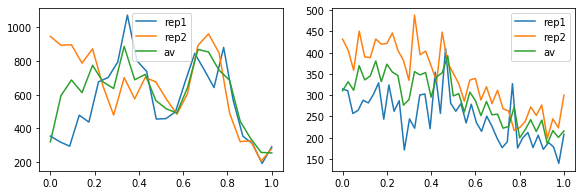

In [45]:
g = 'ENSG00000026025_VIM__10'

plt.figure(figsize=(6*1.6,3))
plt.subplot(121)
plt.plot(np.linspace(0,1,len(mndfsChi[0].columns)), mndfsChi[0].loc[g])
plt.plot(np.linspace(0,1,len(mndfsChi[1].columns)), mndfsChi[1].loc[g])
plt.plot(np.linspace(0,1,len(mndfChi_av.columns)), mndfChi_av.loc[g])
plt.legend(['rep1','rep2','av'])

plt.subplot(122)
plt.plot(np.linspace(0,1,len(mndfsSB[0].columns)), mndfsSB[0].loc[g])
plt.plot(np.linspace(0,1,len(mndfsSB[1].columns)), mndfsSB[1].loc[g])
plt.plot(np.linspace(0,1,len(mndfSB_av.columns)), mndfSB_av.loc[g])
plt.legend(['rep1','rep2','av'])

plt.show()

# germ layer plots

In [46]:
# Alfonso's assigment
germlayer_genes = pd.read_excel('../gene_lineages_v2.xls', sheetname='heatmap_germlayers_v2')
f_germlayer_genes = germlayer_genes.loc[[idx for idx in germlayer_genes.index if germlayer_genes.loc[idx, 'Alfonsos assigment'] in ['Endoderm','Mesoderm','Ectoderm']]]

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [47]:
len(mdf_all)

19458

In [48]:
#col = 'Lineage'
col = 'Alfonsos assigment'

mznfdfchis = mdf_all

hcl_endo = linkage(mznfdfchis.loc[f_germlayer_genes[f_germlayer_genes[col]=='Endoderm']['gene name']], method='ward', metric='euclidean')
hcl_ecto = linkage(mznfdfchis.loc[f_germlayer_genes[f_germlayer_genes[col]=='Ectoderm']['gene name']], method='ward', metric='euclidean')
hcl_meso = linkage(mznfdfchis.loc[f_germlayer_genes[f_germlayer_genes[col]=='Mesoderm']['gene name']], method='ward', metric='euclidean')

dg_endo = dendrogram(hcl_endo, no_labels=True, color_threshold = 7, no_plot=True)
dg_ecto = dendrogram(hcl_ecto, no_labels=True, color_threshold = 7, no_plot=True)
dg_meso = dendrogram(hcl_meso, no_labels=True, color_threshold = 7, no_plot=True)

hcl_endo = getClusterByColor(dg_endo, list(f_germlayer_genes[f_germlayer_genes[col]=='Endoderm']['gene name']))
hcl_ecto = getClusterByColor(dg_ecto, list(f_germlayer_genes[f_germlayer_genes[col]=='Ectoderm']['gene name']))
hcl_meso = getClusterByColor(dg_meso, list(f_germlayer_genes[f_germlayer_genes[col]=='Mesoderm']['gene name']))

hcl_endo = pd.Series({g: hcl  for hcl in hcl_endo for g in hcl_endo[hcl]})
hcl_ecto = pd.Series({g: hcl  for hcl in hcl_ecto for g in hcl_ecto[hcl]})
hcl_meso = pd.Series({g: hcl  for hcl in hcl_meso for g in hcl_meso[hcl]})


/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


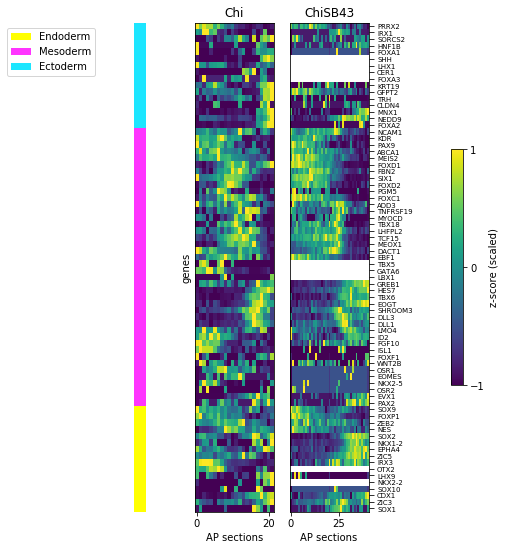

In [49]:
go = list(hcl_endo.sort_values().index)[::-1] + list(hcl_meso.sort_values().index) + list(hcl_ecto.sort_values().index)

plt.figure(figsize=(6.5,9))
plt.subplot(141, frameon = False)
d = {'Ectoderm': 0, 'Endoderm': 1, 'Mesoderm': 2}
cnt = Counter()
y0 = 0; z0 = 0
for g in go[::-1]:
    y = 1.0/len(go)
    c = f_germlayer_genes.set_index('gene name').loc[g, col]
    cnt.update([c])
    if cnt[c] == 1:
        plt.bar([3], [y], bottom = y0, width = 0.3, color = Colors.colors[d[c]])
    else:
        plt.bar([3], [y], bottom = y0, width = 0.3, color = Colors.colors[d[c]], label='_nolegend_')
    y0 += y 
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2,4)
plt.legend(['Endoderm','Mesoderm','Ectoderm'], loc = 1, bbox_to_anchor = (0,1))

plt.subplot(142)
plt.imshow(scalezscore(mdfChi_av.loc[go]), aspect = 'auto')
plt.ylabel('genes'); plt.xlabel('AP sections')
plt.yticks([])
plt.title('Chi')

plt.subplot(143)
plt.imshow(scalezscore(mdfSB_av.loc[go]), aspect = 'auto')
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks([i for i, x in enumerate(go) ], [x.rsplit('_')[1] for i, x in enumerate(go)], fontsize = 7)
plt.xlabel('AP sections')
plt.title('ChiSB43')

plt.subplot(144, frameon= False)
plt.colorbar(label = 'z-score (scaled)', ticks = [-1,0,1], shrink = 0.5)
plt.xticks([]); plt.yticks([])

plt.savefig('../results_postRevJan19/final_figs/heatmap-germlayers.pdf', bbox_inches ='tight')
#pd.Series(go).to_csv(path + 'heatmap_germlayers_v2.txt', sep = '\t')

#plt.savefig(path + 'heatmap_germlayers_Alfonsoannotation_v2.pdf', bbox_inches ='tight')
#pd.Series(go).to_csv(path + 'heatmap_germlayers_Alfonsoannotation_v2.txt', sep = '\t')

plt.show()

In [50]:
mdfChi_av.loc[go].to_csv('../results_postRevJan19/final_figs/heatmap-germlayers_chi.tsv', sep = '\t')
mdfSB_av.loc[go].to_csv('../results_postRevJan19/final_figs/heatmap-germlayers_SB.tsv', sep = '\t')

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
